# Importing Libraries 

In [1626]:
import pandas as pd
import math
import numpy as np 
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor


plt.rcParams['figure.figsize']=14,12

# Importing Dataset

In [1627]:
training_dataset  = pd.read_csv('train_v9rqX0R.csv')
training_dataset.describe()


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


  A summary view of the non-categories fields of the dataset shows that the distribution of the item outlet sales might have outliers, right skewed 

In [1628]:
training_dataset.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [1629]:
training_dataset.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

  A quick check into the different fields to check missing values shows that **Item_weight** (Continous) and **Outlet_Size** (Categorical) have some missing values

## DEALING WITH MISSING VALUES

#### Weight 

In [1630]:
training_dataset.corr().Item_Outlet_Sales

Item_Weight                  0.014123
Item_Visibility             -0.128625
Item_MRP                     0.567574
Outlet_Establishment_Year   -0.049135
Item_Outlet_Sales            1.000000
Name: Item_Outlet_Sales, dtype: float64

In [1631]:
training_dataset[~training_dataset.Item_Weight.isnull()].corr().Item_Outlet_Sales

Item_Weight                  0.014123
Item_Visibility             -0.085334
Item_MRP                     0.620961
Outlet_Establishment_Year    0.012212
Item_Outlet_Sales            1.000000
Name: Item_Outlet_Sales, dtype: float64

To figure out how to manage missing weight fields, I decide to check how significant this field is for the prediction of sales. I did this by checking the correlation of all continous variables by to the **Sales**. From this check i discovered that the weight field is not a significant one and as such might not be neccessary to update.

In [1632]:
training_dataset.groupby(['Outlet_Size']).agg({'Outlet_Size':'count'})

,Outlet_Size
Outlet_Size,
High,932
Medium,2793
Small,2388


In [1633]:
training_dataset.groupby(['Outlet_Location_Type','Outlet_Size', 'Outlet_Type', 'Outlet_Identifier'])\
.agg({'Outlet_Size':'count'})

Outlet_Size
Outlet_Location_Type Outlet_Size Outlet_Type       Outlet_Identifier             
Tier 1               Medium      Supermarket Type1 OUT049                     930
                     Small       Grocery Store     OUT019                     528
                                 Supermarket Type1 OUT046                     930
Tier 2               Small       Supermarket Type1 OUT035                     930
Tier 3               High        Supermarket Type1 OUT013                     932
                     Medium      Supermarket Type2 OUT018                     928
                                 Supermarket Type3 OUT027                     935

 A quick summary of the **Outlet Variables** for known **Outlet Sizes** show that the All **Grocery Store** are **Small** size, but also all of them are in the Tier 1 area. There are also no Small sized outlets in the Tier 3 regions

In [1634]:
training_dataset[training_dataset['Outlet_Size'].isnull()]\
.groupby(['Outlet_Location_Type','Outlet_Type', 'Outlet_Identifier']).agg({'Outlet_Type':'count'})

Outlet_Type
Outlet_Location_Type Outlet_Type       Outlet_Identifier             
Tier 2               Supermarket Type1 OUT017                     926
                                       OUT045                     929
Tier 3               Grocery Store     OUT010                     555

A quick view into the unknown outlet-sizes shows that the Grocery Stores are in the Tier 3 area which makes it difficult to make assumptions are small Sized Outlets. As such I decided to include a new category "Unknown" for the missing Data in the Outlet_Size

In [1635]:
training_dataset['Outlet_Size'] = training_dataset['Outlet_Size'].fillna('Unknown')

# DEALING WITH OUTLIERS

<AxesSubplot:ylabel='Density'>

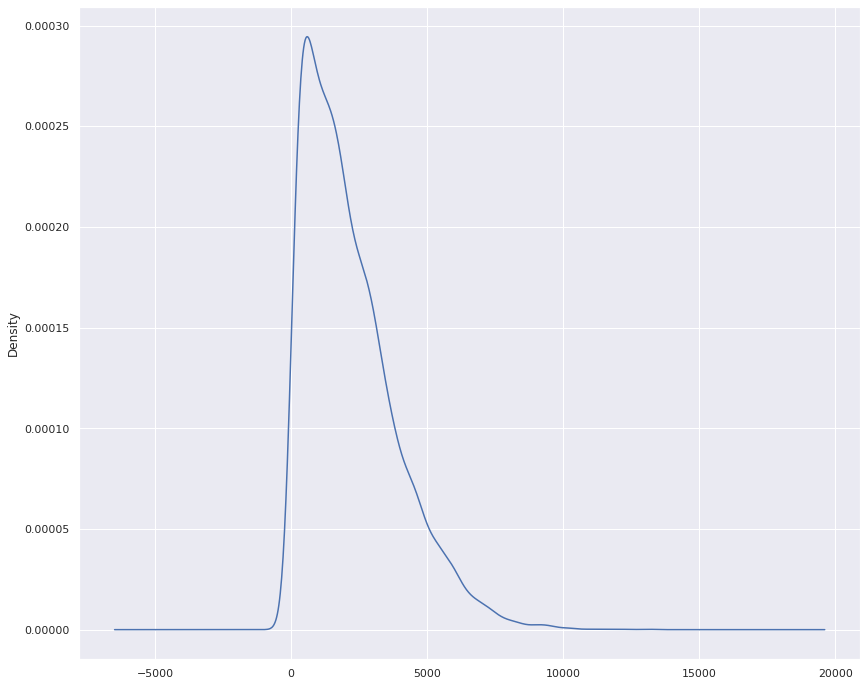

In [1636]:
training_dataset['Item_Outlet_Sales'].plot.kde()

In [1637]:
training_dataset['Item_Outlet_Sales'].quantile([0.000000000001,.02, .04, .05, .10,.90, .95,.98, .99, 0.995, 0.999, 0.9995, 0.9998, 0.99999, 0.999999999 ])

1.000000e-12       33.290000
2.000000e-02      115.476352
4.000000e-02      169.699104
5.000000e-02      188.421400
1.000000e-01      343.552800
9.000000e-01     4570.051200
9.500000e-01     5522.811000
9.800000e-01     6623.831144
9.900000e-01     7366.011720
9.950000e-01     8212.429944
9.990000e-01     9726.761417
9.995000e-01    10293.550965
9.998000e-01    11643.880585
9.999900e-01    13004.352123
1.000000e+00    13086.956539
Name: Item_Outlet_Sales, dtype: float64

In [1638]:
training_dataset = training_dataset[(training_dataset['Item_Outlet_Sales']<training_dataset['Item_Outlet_Sales'].quantile(0.98))\
                                   & (training_dataset['Item_Outlet_Sales']>training_dataset['Item_Outlet_Sales'].quantile(0.0000001))]

In [1639]:
training_dataset['Item_Outlet_Sales'].quantile([0.0000001,.02, .04, .05, .10,.90, .95,.98, .99, 0.995, 0.999, 0.9995, 0.9998, 0.99999, 0.999999999 ])

1.000000e-07      33.956356
2.000000e-02     114.517600
4.000000e-02     167.781600
5.000000e-02     186.424000
1.000000e-01     337.494020
9.000000e-01    4327.700000
9.500000e-01    5088.476370
9.800000e-01    5829.838012
9.900000e-01    6105.572424
9.950000e-01    6338.416000
9.990000e-01    6563.853883
9.995000e-01    6605.857540
9.998000e-01    6615.388800
9.999900e-01    6622.101136
1.000000e+00    6622.712539
Name: Item_Outlet_Sales, dtype: float64

array([[<AxesSubplot:title={'center':'Item_Weight'}>,
        <AxesSubplot:title={'center':'Item_Visibility'}>],
       [<AxesSubplot:title={'center':'Item_MRP'}>,
        <AxesSubplot:title={'center':'Outlet_Establishment_Year'}>],
       [<AxesSubplot:title={'center':'Item_Outlet_Sales'}>,
        <AxesSubplot:>]], dtype=object)

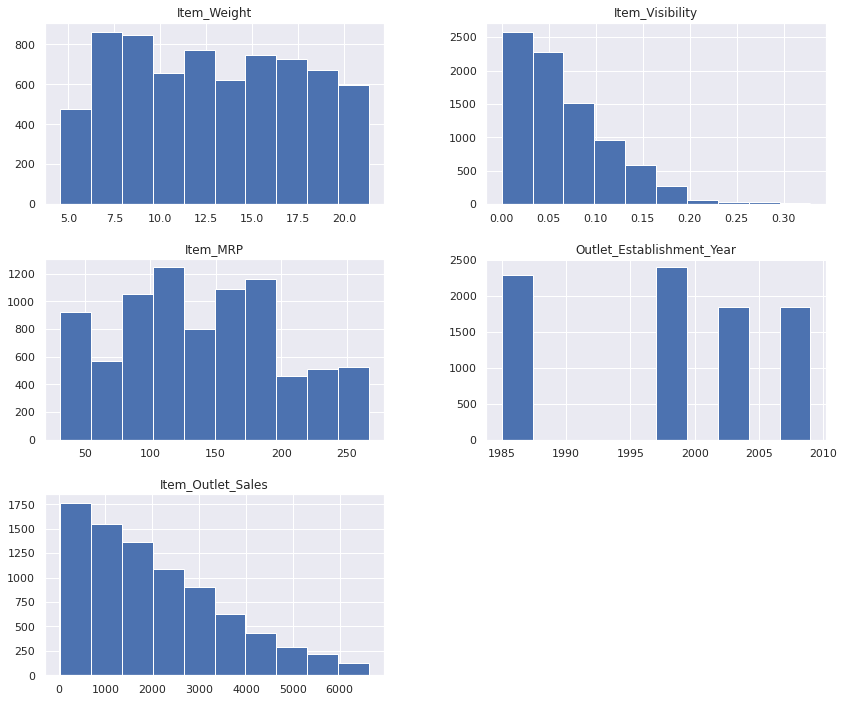

In [1640]:
training_dataset.hist()

In [1641]:
#imputer = SimpleImputer(missing_values="NaN", strategy='mean')
#imputer.fit(training_dataset[['Item_Weight']])

# DEALING WITH CATEGORICAL VALUES 

In [1642]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in training_dataset.columns:
    if training_dataset[i].dtype == 'object':
        training_dataset[i] = le.fit_transform(training_dataset[i])
    
 

In [1643]:
training_columns = training_dataset.drop(columns=['Item_Outlet_Sales']).columns

<AxesSubplot:>

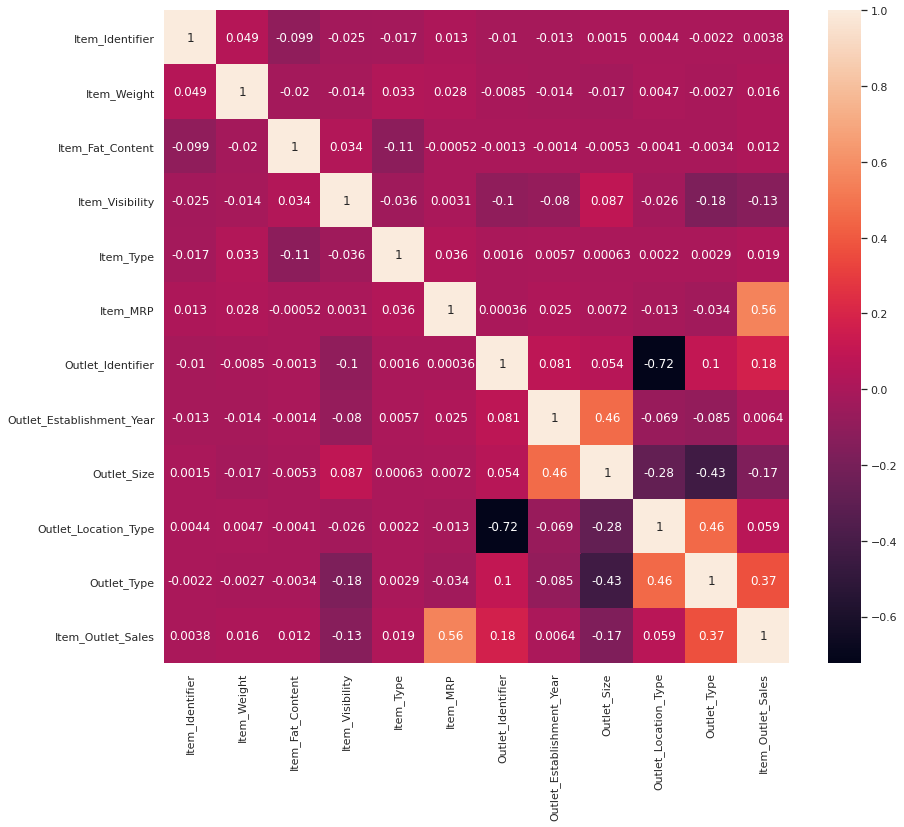

In [1644]:
sns.heatmap(training_dataset.corr(), annot=True)

In [1645]:
training_dataset.corr()['Item_Outlet_Sales'].sort_values(ascending=False)

Item_Outlet_Sales            1.000000
Item_MRP                     0.555141
Outlet_Type                  0.370797
Outlet_Identifier            0.178049
Outlet_Location_Type         0.059333
Item_Type                    0.018842
Item_Weight                  0.016260
Item_Fat_Content             0.011702
Outlet_Establishment_Year    0.006391
Item_Identifier              0.003797
Item_Visibility             -0.132533
Outlet_Size                 -0.167094
Name: Item_Outlet_Sales, dtype: float64

**Outlet Location Type**, **Outlet Size**, **Outlet Identifier**, **Item Visibility** & **Outlet Type** are all correlated with **Items Outlet Sales**
However, to avoid multi-collinearity, some of the fields have to be dropped. 
**Outlet Type** is correlated with **Outlet Location Type**, **Outlet Size**, **Outlet Identifier**, **Item Visibility**. Based on the definition of these fields, this pattern makes sense
1. **Outlet Location Type** seems to determine the **Outlet type**. The positive relationship of 0.46 show that More Type 2 & 3 supermarkets are found in the Tier 3 Location Types, while a Grocery store is only found in Tier 1 areas with some Type 1 supermarkets
2.  **Outlet Type** has a strong correlation with the **Outlet Size** (-0.43) . All Grocery Stores are small-sized, All Type2 & 3 supermarkets are Medium Types. It shows some sort of patterns
3. **Outlet Type** has some correlation with **Outlet Identifier** (0.18). This is mainly as an **Outlet Identifier** can only be one **Outlet Type** 
4.  **Outlet Type** has some correlation with **Item Visibility** (0.13). This understandable to some extent as the visibility of an item can be affected by the structure of the shop.

As such I played with various combinations of variables

1. Item_MRP, Outlet_type 
2. Item_MRP, Outlet_Size, Outlet Identifier 

In [1646]:
X= training_dataset[[ 'Item_MRP', 'Outlet_Type']]
y=np.log(training_dataset['Item_Outlet_Sales'])

In [1647]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

In [1648]:
X_train

,Item_MRP,Outlet_Type
5027,170.3106,3
3161,107.9938,1
5825,106.5306,0
6201,190.9872,1
3099,126.2046,1
...,...,...
6036,115.5808,1
4002,216.7850,1
7216,37.2848,1
7544,242.9512,1


In [1649]:

sc  = StandardScaler()
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)


In [1650]:
X_train

array([[ 0.49706843,  2.33926425],
       [-0.51498133, -0.22726623],
       [-0.53874428, -1.51053147],
       ...,
       [-1.66332376, -0.22726623],
       [ 1.67678082, -0.22726623],
       [ 0.90688842,  1.05599901]])

In [1651]:
import xgboost
XGB = xgboost.XGBRegressor()
Linreg = LinearRegression()
Polyreg = PolynomialFeatures()
SVRreg = SVR()
regr = RandomForestRegressor(max_depth=10, random_state=0)
HR =  HuberRegressor()
RAN = RANSACRegressor()
Theil =  TheilSenRegressor()

In [1652]:
def evaluator(a):
    b = []
    for i in a:
        i.fit(X_train, y_train)
        b.append('Train: {0},Test: {1}'.format(((np.exp(i.predict(X_train))- np.exp(y_train))**2).mean()**0.5,\
                 ((np.exp(i.predict(X_test))-np.exp(y_test))**2).mean()**0.5))
    return b
        
    
    

In [1653]:
evaluator([SVRreg, XGB, regr, Linreg, HR, RAN, Theil])

['Train: 983.3504321709505,Test: 921.4545982909418',
 'Train: 851.9566320487428,Test: 986.0705199688639',
 'Train: 919.740022411295,Test: 963.0762226119789',
 'Train: 1425.9074837767537,Test: 1374.3432295131356',
 'Train: 1308.3682049157155,Test: 1252.5890349018277',
 'Train: 1298.473273972635,Test: 1237.7805314659056',
 'Train: 1473.4038240642049,Test: 1396.2123278766658']

I decided to fit the different regressors to see how they perform. I discover that SVM Regressor, XGBoost, RandomForest seems to perform best. 
SVM seemed to do the best, as it was good with generalizing the model, followed by Random Forest. XGB seems. to overfitted the model as the prediction of the train set varies very much with the test set

# IMPORTING TEST SET & PREDICTION

In [1654]:
test_data = pd.read_csv('test_AbJTz2l.csv')

In [1655]:
training_columns = training_dataset.drop(columns=['Item_Outlet_Sales']).columns

In [1657]:
def data_cleaning(training_dataset):
    for i in training_dataset.columns:
        if training_dataset[i].dtype == 'object':
            training_dataset[i] = le.fit_transform(training_dataset[i])
    training_dataset = training_dataset[[ 'Item_MRP', 'Outlet_Type']]
    training_dataset = sc.fit_transform(training_dataset)
    return  training_dataset

 
    

In [1658]:
Final = data_cleaning(test_data)

In [1660]:
A = Linreg.predict(Final)
B = XGB.predict(Final)
C = SVRreg.predict(Final)
D = regr.predict(Final)

In [1662]:
Finals=test_data[['Item_Identifier','Outlet_Identifier']]

In [1663]:
Finals['Item_Outlet_Sales']=np.exp(C)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1664]:
Finals.to_csv('A.csv', index=False)

In [1665]:
Finals.sort_values(by=['Item_Outlet_Sales'])

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
30,1459,4,76.350434
674,973,0,77.354345
5016,413,4,77.567776
2522,1152,0,78.000345
2179,801,4,78.587018
...,...,...,...
861,615,5,4757.116089
2911,716,5,4757.212570
1478,180,5,4757.317908
4406,1027,5,4757.319617


TypeError: ufunc 'exp' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''